# day 13: Hyperparameter Search

# Objectives

* See how to do grid search using sklearn
* See how to do random search using sklearn

# Outline

* [Part 1: Practical multiclass hyperparameters for MLPs](#part1)
* [Part 2: Grid search](#part2)
* [Part 3: Random search](#part3)

We expect you can at least run through this whole notebook during the lab time in class.

There are fewer little exercises here, more of a big demonstration and a few chances to reflect on it.

# Takeaways

* To do any hyper search, you need to think carefully about selecting the performance metric and source of heldout data
* To do randomized search, think carefully about what *distributions* you pick
* Always provide `random_state` values so you can reproduce your results

* sklearn offers a standardized interface for doing hyperparameter searches
* Random search may be more efficient than grid search (in terms of quality of solution vs. time spent on search)



In [1]:
import numpy as np

In [2]:
import scipy.stats

In [3]:
import pandas as pd

In [4]:
import sklearn.neural_network

In [5]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setup : Recipe for a toy dataset with 4 possible classes and 2 features

We'll create a fun multi-class dataset.

Don't need to know the details here. Just skip ahead to see the picture to understand.

In [6]:
def make_multi_class_blob_dataset(
        n_per_blob=50, n_blob_per_class=3, n_class=4,
        stddev=1.0, noise_frac=0.02,
        x_max=5.0,
        problem_seed=2345, data_seed=101):
    problem_prng = np.random.RandomState(int(problem_seed))
    data_prng = np.random.RandomState(int(data_seed))

    x_list = list()
    y_list = list()
    
    N = n_per_blob * n_class * n_blob_per_class
    
    for blob_id in range(n_class * n_blob_per_class):
        
        mu_2 = problem_prng.uniform(low=-x_max, high=x_max, size=2)
        
        is_horiz = problem_prng.rand() < 0.5
        if is_horiz:            
            cov_22 = np.diag(np.square([stddev, stddev/4]))
        else:
            cov_22 = np.diag(np.square([stddev/4, stddev]))            

        xblob_N2 = data_prng.multivariate_normal(
            mu_2, cov_22, size=n_per_blob)
        x_list.append(xblob_N2)

        yblob_N = (blob_id % n_class) * np.ones(n_per_blob)
        y_list.append(yblob_N)

    x_N2 = np.vstack(x_list)
    assert x_N2.shape == (N, 2)
    
    y_N = np.hstack(y_list).astype(np.int32)
    assert y_N.shape == (N,)

    # Shuffle the order
    perm_ids = data_prng.permutation(N)
    x_N2 = x_N2[perm_ids].copy()
    y_N = y_N[perm_ids].copy()

    # Insert some noise to small fraction of examples
    n_noise = int(np.ceil(noise_frac * N))
    x_N2[:n_noise, :] = data_prng.uniform(
        low=-x_max,
        high=x_max, size=(n_noise,2))

    # Reshuffle again
    perm_ids = data_prng.permutation(N)
    x_N2 = x_N2[perm_ids].copy()
    y_N = y_N[perm_ids].copy()
    return x_N2, y_N

# Create and display a toy dataset with 4 possible classes and 2 features

In [7]:
# Create training and validation sets

xtrain_N2, ytrain_N = make_multi_class_blob_dataset(n_per_blob=100, data_seed=123)
xvalid_N2, yvalid_N = make_multi_class_blob_dataset(n_per_blob=25, data_seed=123)

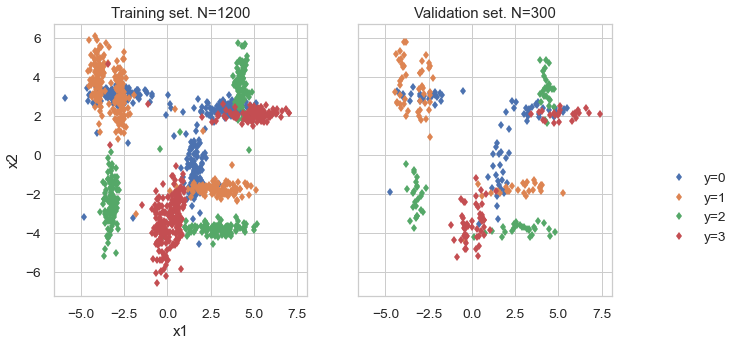

In [8]:
# Make a picture of the data, coloring each point by its class label

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True, sharey=True)
for c in range(4):
    ax[0].plot(xtrain_N2[ytrain_N == c,0], xtrain_N2[ytrain_N == c,1], 'd')
    ax[1].plot(xvalid_N2[yvalid_N == c,0], xvalid_N2[yvalid_N == c,1], 'd', label='y=%d' % c)

ax[0].set_xlabel('x1');
ax[0].set_ylabel('x2');
ax[0].set_title("Training set. N=%d" % ytrain_N.size)
ax[1].set_title("Validation set. N=%d" % yvalid_N.size);
ax[1].legend(bbox_to_anchor=(1.5, 0.5));

<a id="part1"></a>

# Part 1: Train a multi-class MLP

In [9]:
mlp = sklearn.neural_network.MLPClassifier(
    hidden_layer_sizes=[32],
    solver='lbfgs',
    max_iter=1000)

Fit the model to our dataset. We may not converge, but should get pretty good.

In [10]:
mlp.fit(xtrain_N2, ytrain_N)

/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, solver='lbfgs')

In [11]:
np.set_printoptions(precision=5, suppress=True)

### Show the true class labels of first 5 examples in validation set

In [12]:
yvalid_N[:5]

array([0, 0, 3, 0, 2], dtype=int32)

### Predict probabilities for these first 5 examples (4 classes means 4 column output)

In [13]:
proba_N4 = mlp.predict_proba(xvalid_N2[:5])

In [14]:
proba_N4

array([[0.97669, 0.0004 , 0.00245, 0.02045],
       [0.79471, 0.19439, 0.005  , 0.00591],
       [0.     , 0.00001, 0.00087, 0.99912],
       [0.23933, 0.76027, 0.00038, 0.00002],
       [0.00003, 0.00214, 0.99782, 0.     ]])

<a id="part2"></a>

## Exercise 1a: Can you write numpy code to make hard label predictions from these probas?

Remember, usually we want to predict the class that has *highest* probability.

Hint: Take a look at NumPy's argmax function (docs: <https://numpy.org/doc/stable/reference/generated/numpy.argmax.html>)

**Input**: 2D array, shape (N,4) of dtype float64, where each row contains nonnegative entries that sum to one.

**Desired Output**: 1D array, shape (N,) of dtype int32, where each entry indicates one of the 4 possible classes

In [15]:
yhat_N = proba_N4 # TODO write numpy code to predict *integer* class label predictions from these probas

In [16]:
print(yhat_N)

[[0.97669 0.0004  0.00245 0.02045]
 [0.79471 0.19439 0.005   0.00591]
 [0.      0.00001 0.00087 0.99912]
 [0.23933 0.76027 0.00038 0.00002]
 [0.00003 0.00214 0.99782 0.     ]]


# Part 2: Grid Search for best hyperparameters

We will follow the procedure discussed in class. Remember, whenever you do a grid search (e.g. in your project), you should clearly document these choices since they all matter in the final results.

1) Select relevant hyperparameters and possible values

We will look at

* NN model size `hidden_layer_sizes`: [4] or [16] or [64]

* Regularization strength `alpha` : 0.0 or 0.0001 or 0.01 or 1.00

* 2 different `random_state` values, which control the random initialization.

2) Select performance metric 

* We will use *accuracy*

3) Select source of heldout data

* We will use the fixed validation set defined earlier


### Step 1: Create hyperparameter grid

In [17]:
my_parameter_grid_by_name = dict(
    hidden_layer_sizes=[
        4,
        16,
        64,
        ],
    alpha=[
        0.0,
        0.0001,
        0.01,
        1.00,
        ],
    random_state=[  # try two possible seeds to initialize parameters
        101, 202,
        ],
    )

### Step 2: Define 'accuracy' as the intended measure of merit

In [18]:
my_scoring_metric_name = 'accuracy'

### Step 2: Define the predefined validation set as the split

Below, we process our observed train and valid sets so they fit into the format needed by sklearn.

Basically, sklearn's search routines require consuming a "splitter" object that controls how to divide a big dataset into splits. We need to satisfy that interface.

In [19]:
xall_N2 = np.vstack([xtrain_N2, xvalid_N2])
yall_N = np.hstack([ytrain_N, yvalid_N])

In [20]:
valid_indicators_N = np.hstack([
    -1 * np.ones(ytrain_N.size), # -1 means never include this example in any test split
    0  * np.ones(yvalid_N.size), #  0 means include in the first test split (we count starting at 0 in python)
    ])

In [21]:
# Create splitter object using Predefined Split

my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators_N)

In [22]:
my_splitter.get_n_splits()

1

In [23]:
# Verify the splitter only produces one split and it is the intended one
for tr_idx, te_idx in my_splitter.split(xall_N2, yall_N):
    assert np.allclose(xall_N2[te_idx], xvalid_N2)
    assert np.allclose(yall_N[te_idx], yvalid_N)

### Now that we've set up everything, we'll prepare to do the search, using GridSearchCV

Take a look at the official docs:

<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html>

The *constructor* of GridSearchCV takes the following values (among other possibilities)

```
sklearn.model_selection.GridSearchCV(
    estimator,
    param_grid,
    scoring=None,
    cv=None,
    ...
    )
```

In [24]:
# Create a custom searcher object with all our settings in place.

grid_searcher = sklearn.model_selection.GridSearchCV(
    mlp,
    my_parameter_grid_by_name,
    scoring=my_scoring_metric_name,
    cv=my_splitter,
    refit=False)

### Run the search!

We run a search by calling "fit" on our searcher object, just like as if it were a simple classifier.

Internally, it will loop over all configurations, try each one, and store the results.

We expect this will produce many "failed to converge" errors. Just ignore these. 

In [25]:
grid_searcher.fit(xall_N2, yall_N)

/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multila

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=MLPClassifier(hidden_layer_sizes=[32], max_iter=1000,
                                     solver='lbfgs'),
             param_grid={'alpha': [0.0, 0.0001, 0.01, 1.0],
                         'hidden_layer_sizes': [4, 16, 64],
                         'random_state': [101, 202]},
             refit=False, scoring='accuracy')

### Get the search results into a pandas DataFrame

This will make it easy to view and manage the results.

In [26]:
gsearch_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()
print("Dataframe has shape: %s" % (str(gsearch_results_df.shape)))
n_trials_grid_search = gsearch_results_df.shape[0]

print("Dataframe has columns:")
for c in gsearch_results_df.columns:
    print("-- %s" % c)

Dataframe has shape: (24, 12)
Dataframe has columns:
-- mean_fit_time
-- std_fit_time
-- mean_score_time
-- std_score_time
-- param_alpha
-- param_hidden_layer_sizes
-- param_random_state
-- params
-- split0_test_score
-- mean_test_score
-- std_test_score
-- rank_test_score


### Rearrange the results in a pleasant order.

Don't need to understand too much about this block.

In [27]:
param_keys = ['param_hidden_layer_sizes', 'param_alpha', 'param_random_state']

# Rearrange row order so it is easy to skim
gsearch_results_df.sort_values(param_keys, inplace=True)

### Pretty print the results of each configuration

In [28]:
gsearch_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

,param_hidden_layer_sizes,param_alpha,param_random_state,split0_test_score,rank_test_score
0,4,0,101,0.656667,22
1,4,0,202,0.753333,19
6,4,0.0001,101,0.650000,23
7,4,0.0001,202,0.750000,21
12,4,0.01,101,0.646667,24
13,4,0.01,202,0.763333,18
18,4,1,101,0.823333,17
19,4,1,202,0.753333,19
2,16,0,101,0.870000,1
3,16,0,202,0.850000,9


## Discussion 2a: Look over the results above. Which configuration has the best score? Do any other configurations come close?


Remember "score" here is accuracy on validation set.

TODO write your answer here, then discuss with group.

## Now, recreate the best model found by the grid search

In [29]:
bestg_mlp = mlp.set_params(**grid_searcher.best_params_)
print(bestg_mlp)

MLPClassifier(alpha=0.0, hidden_layer_sizes=16, max_iter=1000, random_state=101,
              solver='lbfgs')


Fit it again. Sadly, the grid search doesn't store the fit we already did :(

In [30]:
bestg_mlp.fit(xtrain_N2, ytrain_N)

/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.0, hidden_layer_sizes=16, max_iter=1000, random_state=101,
              solver='lbfgs')

### Evaluate this model's score on the validation set (will do predict and then compute accuracy of those predictions)

In [31]:
bestg_mlp.score(xvalid_N2, yvalid_N)

0.87

## Discussion 2b: Does this match your validation set performance in the table above?

<a id="part3"></a>

# Part 3: Random Search

## How to define a *distribution*

In [32]:
# We can create a *distribution* object using scipy.stats

dist = scipy.stats.randint(4, 64)

In [33]:
# All distributions support a 'rvs' method to draw samples
for trial in range(5):
    print("sample %d: %d" % (trial, dist.rvs()))

sample 0: 13
sample 1: 6
sample 2: 62
sample 3: 44
sample 4: 13


## Define distributions over each of our hyperparameters

* hidden layer sizes will be uniform over integers between 2 and 70
* alpha will be uniform over the interval 0 to 1.0
* We'll have two possible values for random state (as before)

In [34]:
my_parameter_distributions_by_name = dict(
    hidden_layer_sizes=scipy.stats.randint(2, 70),
    alpha=scipy.stats.uniform(0.0, 1.0),
    random_state=[  # try two possible seeds to initialize parameters
        101, 202,
        ],
    )

### Decide how many trials to do

We'll use only a fraction of the total number of grid search trials

In [35]:
n_trials_rand_search = n_trials_grid_search // 2
print(n_trials_rand_search)

12


### Create object to do the random search

Uses sklearn's RandomizedSearchCV, see the docs here:

<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html>

Has very similar interface as GridSearchCV

In [36]:
my_rand_searcher = sklearn.model_selection.RandomizedSearchCV(
    mlp,
    my_parameter_distributions_by_name,
    scoring=my_scoring_metric_name,
    cv=my_splitter,
    n_iter=n_trials_rand_search,
    random_state=101, # same seed means same results everytime we repeat this code
    )

### Run the search!

In [37]:
my_rand_searcher.fit(xall_N2, yall_N)

/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multila

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
                   estimator=MLPClassifier(alpha=0.0, hidden_layer_sizes=16,
                                           max_iter=1000, random_state=101,
                                           solver='lbfgs'),
                   n_iter=12,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1b4b79e8>,
                                        'hidden_layer_sizes': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1b4b7b38>,
                                        'random_state': [101, 202]},
                   random_state=101, scoring='accuracy')

### Collect random search results into a Pandas dataframe

In [38]:
rsearch_results_df = pd.DataFrame(my_rand_searcher.cv_results_).copy()
print("Dataframe has shape: %s" % (str(rsearch_results_df.shape)))

print("Dataframe has columns:")
for c in rsearch_results_df.columns:
    print("-- %s" % c)


Dataframe has shape: (12, 12)
Dataframe has columns:
-- mean_fit_time
-- std_fit_time
-- mean_score_time
-- std_score_time
-- param_alpha
-- param_hidden_layer_sizes
-- param_random_state
-- params
-- split0_test_score
-- mean_test_score
-- std_test_score
-- rank_test_score


### Pretty print the results of the random search

In [39]:
rsearch_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

,param_hidden_layer_sizes,param_alpha,param_random_state,split0_test_score,rank_test_score
0,65,0.516399,202,0.856667,5
1,11,0.171522,202,0.850000,8
2,65,0.289342,101,0.850000,8
3,66,0.266189,101,0.860000,4
4,42,0.554228,202,0.856667,5
5,10,0.0254969,202,0.846667,11
6,61,0.232354,101,0.850000,8
7,21,0.603548,101,0.856667,5
8,2,0.946284,202,0.553333,12
9,10,0.137869,101,0.863333,2


## Discussion 3a: What are the best hyperparameters here? How do they compare to those from Grid Search?

TODO discuss

### Rebuild the best model and verify its performance

In [40]:
bestr_mlp = mlp.set_params(**my_rand_searcher.best_params_)
print(bestr_mlp)

MLPClassifier(alpha=0.6026314908315643, hidden_layer_sizes=30, max_iter=1000,
              random_state=202, solver='lbfgs')


In [41]:
bestr_mlp.fit(xtrain_N2, ytrain_N)

/Users/mhughes/miniconda3/envs/comp135_2020f_env/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=0.6026314908315643, hidden_layer_sizes=30, max_iter=1000,
              random_state=202, solver='lbfgs')

In [42]:
bestr_mlp.score(xvalid_N2, yvalid_N)

0.8666666666666667

## Exercise 3b: Go back and repeat this random search with more trials... can you do much better?

## Exercise 3c: Go back and repeat either search with even more units per layer.... how much better do you get?

## Exercise 3d: Go back and repeat either search with even layers .... how much better do you get?